In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import os
from pathlib import Path
import pickle as pkl

In [2]:
project_dir = Path.cwd().parent
report_dir = project_dir / 'reports'
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'
os.chdir(project_dir)

In [31]:
from src.data import make_dataset
from src.data import submit_predictions
from src.visualization import visualize

In [5]:
competition = 'uts-advdsi-nba-career-prediction'
make_dataset.download_data(competition=competition,
                           path=raw_data_dir,
                           unzip=True)
df = pd.read_csv(raw_data_dir / 'train.csv')

In [6]:
print(df['TARGET_5Yrs'].value_counts())

1    6669
0    1331
Name: TARGET_5Yrs, dtype: int64


In [7]:
target = df.pop('TARGET_5Yrs')

In [8]:
df.drop('Id_old', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)

In [9]:
df.columns = df.columns.str.strip()
df

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,80,24.3,7.8,3.0,6.4,45.7,0.1,0.3,22.6,2.0,2.9,72.1,2.2,2.0,3.8,3.2,1.1,0.2,1.6
1,75,21.8,10.5,4.2,7.9,55.1,-0.3,-1.0,34.9,2.4,3.6,67.8,3.6,3.7,6.6,0.7,0.5,0.6,1.4
2,85,19.1,4.5,1.9,4.5,42.8,0.4,1.2,34.3,0.4,0.6,75.7,0.6,1.8,2.4,0.8,0.4,0.2,0.6
3,63,19.1,8.2,3.5,6.7,52.5,0.3,0.8,23.7,0.9,1.5,66.9,0.8,2.0,3.0,1.8,0.4,0.1,1.9
4,63,17.8,3.7,1.7,3.4,50.8,0.5,1.4,13.7,0.2,0.5,54.0,2.4,2.7,4.9,0.4,0.4,0.6,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,32,9.2,1.8,0.7,1.8,40.3,-0.1,-0.2,23.1,0.4,0.6,65.7,0.3,1.8,1.9,0.5,0.3,0.2,0.4
7996,54,6.0,1.8,0.7,1.4,48.7,0.1,0.1,3.1,0.2,0.4,70.1,1.0,1.1,2.0,0.1,0.0,0.3,0.3
7997,85,28.2,10.7,4.0,9.0,45.1,0.2,0.6,23.6,2.8,3.9,69.7,1.0,2.1,3.1,3.4,1.2,0.2,1.8
7998,39,7.7,2.5,1.0,2.3,40.1,-0.3,-0.5,13.3,0.6,0.7,74.3,0.4,0.6,0.9,0.2,0.3,0.3,0.5


In [10]:
df.isnull().sum()

duplicate = df.duplicated()
print(duplicate.sum())

0


In [11]:
from imblearn.over_sampling import SMOTE 

In [12]:
scaler = StandardScaler()
df_cleaned = scaler.fit_transform(df)

In [13]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(df_cleaned, target)

print(f'''Shape of X before SMOTE: {df.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (8000, 19)
Shape of X after SMOTE: (13338, 19)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: TARGET_5Yrs, dtype: float64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=8)

In [15]:
X_test

array([[ 0.37633754, -0.87949075, -0.93669839, ..., -1.24637649,
        -0.00554072, -1.26806809],
       [-0.0945194 , -1.03111353, -1.03256468, ..., -1.10080177,
        -0.14765733, -1.0477545 ],
       [ 1.59029069,  1.04349704,  1.53594318, ...,  1.84325645,
         1.04117255,  1.71763572],
       ...,
       [-1.57559601,  0.11709992,  0.33856468, ..., -0.53090186,
         0.02740114,  0.66045036],
       [-0.22415727, -0.59866487, -0.58527364, ..., -0.66112901,
         0.01849247, -1.10524449],
       [-0.22069987, -1.20615771, -1.196511  , ..., -0.85546358,
        -0.17687585, -0.63294597]])

In [16]:
from sklearn import svm

clf = svm.SVC(kernel='linear', probability = True) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [17]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6622938530734632


In [18]:
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.6860371267150929
Recall: 0.6240822320117474


In [19]:
clf.score(X_test, y_test)
clf.predict_proba(X_test)

array([[0.48752271, 0.51247729],
       [0.48285455, 0.51714545],
       [0.16008506, 0.83991494],
       ...,
       [0.70632921, 0.29367079],
       [0.51964098, 0.48035902],
       [0.62528909, 0.37471091]])

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[917 389]
 [512 850]]


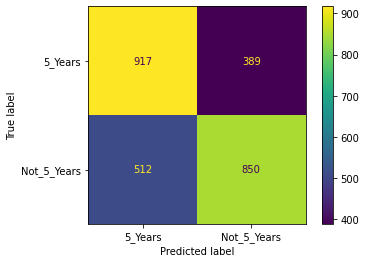

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['5_Years','Not_5_Years'])
cmd.plot()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1306
           1       0.69      0.62      0.65      1362

    accuracy                           0.66      2668
   macro avg       0.66      0.66      0.66      2668
weighted avg       0.66      0.66      0.66      2668



In [23]:
roc=roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
roc

0.7316986100523284

In [24]:
df1 = pd.read_csv(raw_data_dir / 'test.csv')
test_id = df1.pop('Id')
df1.drop('Id_old', axis=1, inplace=True)

In [25]:
#df2 = df1.drop(['FG%', '3P%', 'FT%'], axis = 1) 
df1_cleaned = scaler.fit_transform(df1)

In [26]:
final = clf.predict_proba(df1_cleaned)[:,1]

In [27]:
final

array([0.5       , 0.46458421, 0.68902375, ..., 0.31269233, 0.81292664,
       0.38039685])

## Submit Predictions

In [ ]:
submit_predictions.submit_predictions(clf, df1, test_id,"13684182_week2_svm_smote", pred_path=processed_data_dir/'13684182_week2_svm_smote.csv')

## Save Model

In [29]:
file_name = models_dir /'13684182_week2_svm_smote.sav'
pkl.dump(clf, open(file_name, 'wb'))

## Load Model

In [30]:
model = pkl.load(open(file_name,'rb'))

## Visualise Model

 class 1 :  1362
 class 0 :  1306
Confusion Matrix: 
 [[917 389]
 [512 850]]
Accuracy:  0.6622938530734632
AUC:  0.7316986100523284
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1306
           1       0.69      0.62      0.65      1362

    accuracy                           0.66      2668
   macro avg       0.66      0.66      0.66      2668
weighted avg       0.66      0.66      0.66      2668



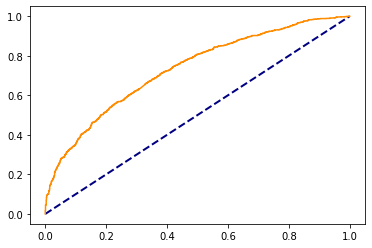

In [32]:
visualize.classification_reports(model,X_test,y_test)